
# Aşama - 1

- Katsayılar yazılıp fonksiyon alınacak
- Sinyali periyodik yap
- Periyodik sinyalin FTsini al
- Tonları spektral puritye ye (Frekans domaininde) göre seçip yeni sinyalin ton listesini al
- Sinusoidal reconstruction yap
- Toplanacak ==> New time domain signal

V_rmsd hesabı yapılacak
Farklı sampling değerleri için ve spectral purityler için 150 uV/V V_rmsd mümkün olan minimum ton sayısı ile elde edilecek.

Input : Hocanın verdiği katsayı, denklem  
Optimizasyon parametreleri : Fs, Spectral purity dB  
Output : Seçilen tonlar - Reconstruct edilmiş sinyal

In [1]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 17,
    "xtick.labelsize": 17,
    "ytick.labelsize": 17,
    "legend.fontsize": 15,
    "figure.titlesize": 14,
    "lines.linewidth": 3,
    "lines.markersize": 8,
    "axes.grid": False,
    "axes.grid.which": "both",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "grid.alpha": 0.7,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": False,
    "ytick.right": False,
    "xtick.bottom": False,
    "ytick.left": False,
    "xtick.minor.visible": False,
    "ytick.minor.visible": False,
    "axes.spines.top": True,
    "axes.spines.right": True,
    "axes.linewidth": 1.2,
    "legend.frameon": True,
    "legend.framealpha": 0.8,
    "legend.fancybox": True,
    "legend.loc": "best",
    "font.size": 25,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "cm"
})

fs_ref = 1.400 GHz | N_ref = 11,508,000 | Δf = 121.654501 Hz


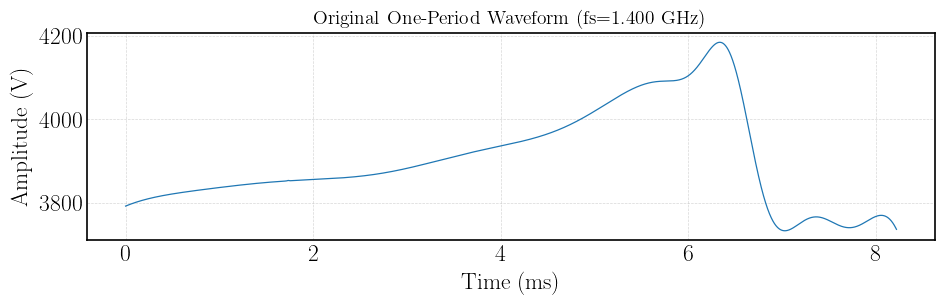

In [2]:
import numpy as np
import csv
from helpers import *
from constants import *

# ---------- Build original at 1.4 GHz ----------
x_ref, dt_ref = gen_one_period(FS_REF)
N_ref = x_ref.size
delta_f = 1.0 / T
print(f"fs_ref = {fmt_fs(FS_REF)} | N_ref = {N_ref:,} | Δf = {delta_f:.6f} Hz")

# ---------- Time plot (decimated to be fast) ----------
max_time_points = 20000
if N_ref > max_time_points:
    idx = np.linspace(0, N_ref - 1, max_time_points, dtype=int)
    t_plot = idx * dt_ref
    x_plot = x_ref[idx]
else:
    t_plot = np.arange(N_ref) * dt_ref
    x_plot = x_ref

plt.figure(figsize=(10, 3.6))
plt.plot(t_plot * 1e3, x_plot, lw=0.9)
plt.title(f"Original One-Period Waveform (fs={fmt_fs(FS_REF)})")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (V)")
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

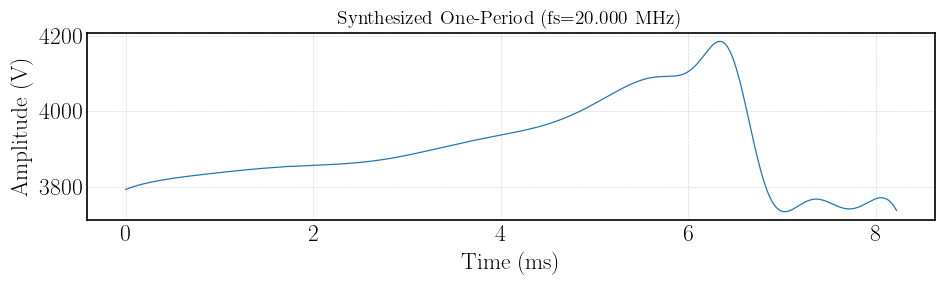

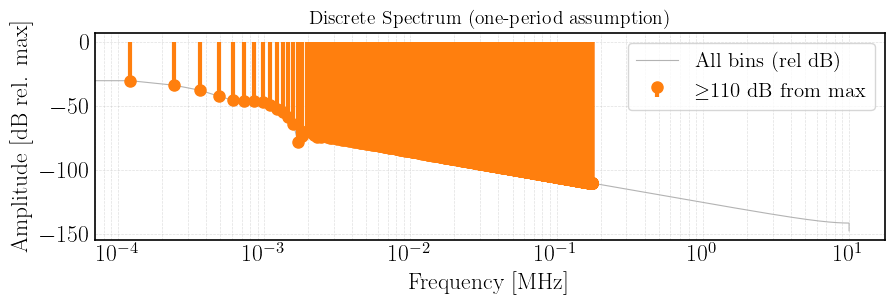

In [3]:
# ---------- Test choosing tones with 20mhz and 110db spectral purity ----------
x_20, dt_20 = gen_one_period(20e6)
tones2, spec2 = period_spectrum_select_tones(
     x=x_20,
     fs=20e6,
     dt=dt_20,
     db_floor_db=110,            
     freq_max=None,            
     top_k=None,               
     plot_time=True,
     plot_spectrum=True,
     save_txt=False,             
)

[Case 1] fs=2e+07 Hz | floor=60 dB | tones=13 | metric=952.928 µV/V → FAIL (≤ 150.0)


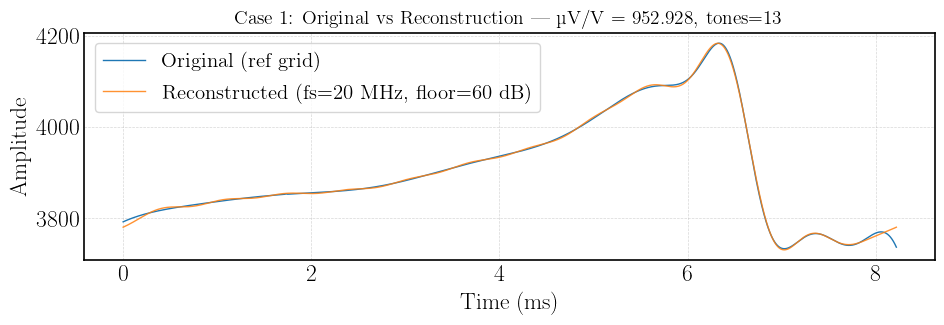

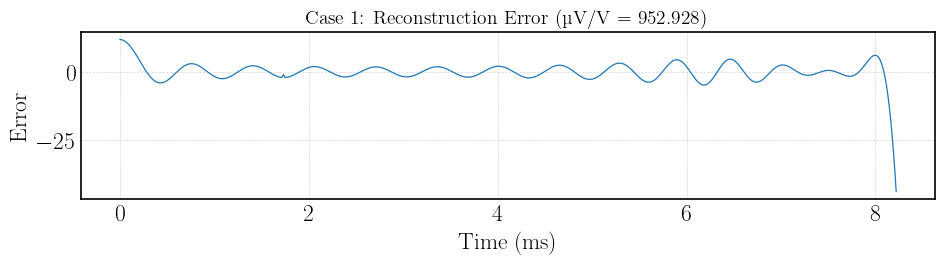

[Case 2] fs=1e+08 Hz | floor=60 dB | tones=13 | metric=952.928 µV/V → FAIL (≤ 150.0)


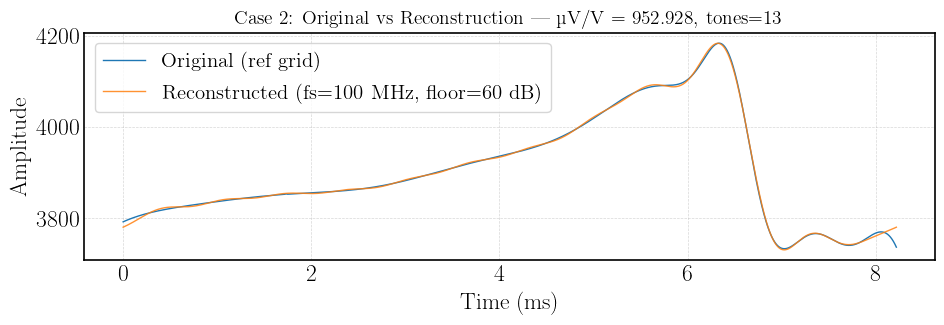

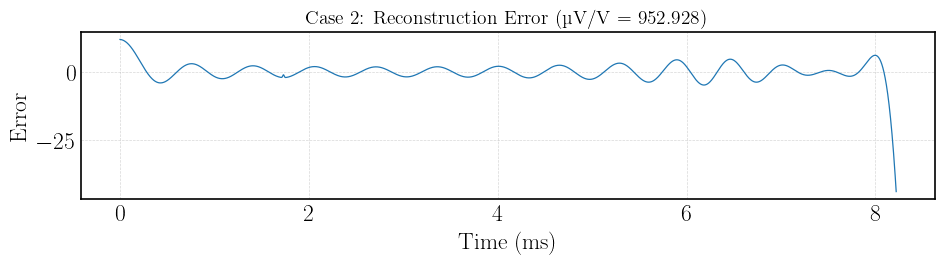

[Case 3] fs=1e+08 Hz | floor=80 dB | tones=46 | metric=474.243 µV/V → FAIL (≤ 150.0)


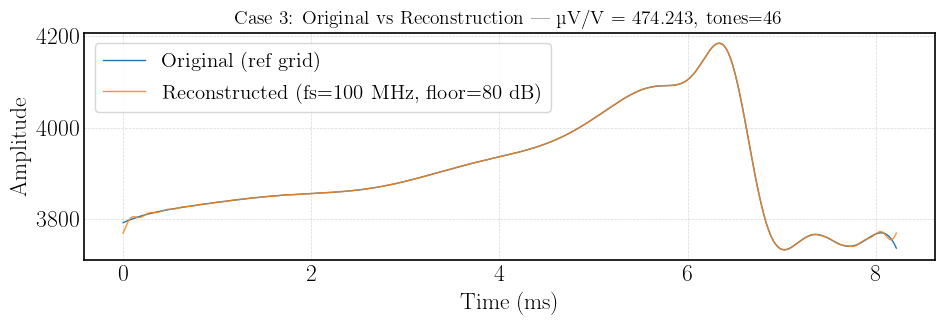

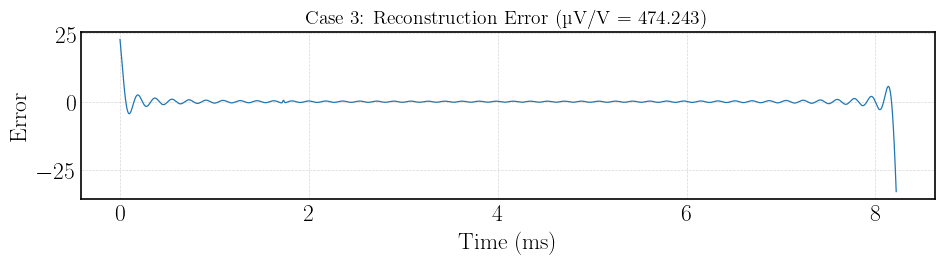

In [4]:
# --------- params: try a few cases here ---------
cases = [
    (20e6, 60),   # (fs, db_floor_dB)
    (100e6, 60),
    (100e6, 80),
]

# Reference grid
N_ref = x_ref.size
t_ref = np.linspace(0.0, T, N_ref, endpoint=False)

# Decimation for plotting
if N_ref > MAX_PLOT_POINTS:
    idx_plot = np.linspace(0, N_ref-1, MAX_PLOT_POINTS, dtype=int)
else:
    idx_plot = slice(None)

# --------- run and plot each case ---------
for i, (fs, dbf) in enumerate(cases, start=1):
    # Build tones at this fs with the given dB floor (no plotting, no saving)
    x_synth, dt_synth = gen_one_period(fs)

    tones, _ = period_spectrum_select_tones(
        x_synth, fs, dt_synth, db_floor_db=dbf,
        plot_time=False, plot_spectrum=False, save_txt=False
    )

    x_hat = cosine_sum_on_ref_grid(tones, N_ref) # Construct each case with same points as reference
    metric = metric_uVrms_per_V(x_ref, x_hat)
    print(f"[Case {i}] fs={fs:.3g} Hz | floor={dbf:.0f} dB | tones={tones.shape[0]} | "
          f"metric={metric:.3f} µV/V → {'PASS' if metric<=UV_PER_V_THRESHOLD else 'FAIL'} (≤ {UV_PER_V_THRESHOLD:.1f})")

    # Plot: Original vs Reconstructed
    plt.figure(figsize=(10, 3.8))
    plt.plot(t_ref[idx_plot]*1e3, x_ref[idx_plot], lw=1.0, label="Original (ref grid)")
    plt.plot(t_ref[idx_plot]*1e3, x_hat[idx_plot], lw=1.0, alpha=0.85,
             label=f"Reconstructed (fs={fs/1e6:.0f} MHz, floor={dbf:.0f} dB)")
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude")
    plt.title(f"Case {i}: Original vs Reconstruction  |  µV/V = {metric:.3f}, tones={tones.shape[0]}")
    plt.grid(True, alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot: Error waveform
    err = x_ref - x_hat
    plt.figure(figsize=(10, 3.2))
    plt.plot(t_ref[idx_plot]*1e3, err[idx_plot], lw=0.9)
    plt.xlabel("Time (ms)")
    plt.ylabel("Error")
    plt.title(f"Case {i}: Reconstruction Error (µV/V = {metric:.3f})")
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()

In [5]:
# ===== Example run (edit grids as needed; no plots) =====
fs_grid = [10e3, 50e3, 100e3, 500e3, 1e6, 5e6, 10e6, 100e6]
dbfloor_grid = [60, 70, 80, 90, 100]
results, best, failing = sweep_optimize_cosine_sum(
     fs_grid, dbfloor_grid,
     x_ref, N_ref,
     threshold_uV_per_V=151.0,
     save_csv=True, csv_path="sweep_results.csv",
     save_best_tone_list=True, best_tone_fname=None, blank_col2=False
 )
if best:
     print(f"BEST → fs={best['fs']:.3g} Hz, floor={best['db_floor_db']:.0f} dB, "
           f"tones={best['num_tones']}, metric={best['metric_uV_per_V']:.3f} µV/V")

100%|██████████| 5/5 [00:27<00:00,  5.40s/it]


10.000 kHz is done


100%|██████████| 5/5 [01:28<00:00, 17.68s/it]


50.000 kHz is done


100%|██████████| 5/5 [02:12<00:00, 26.57s/it]


100.000 kHz is done


100%|██████████| 5/5 [02:22<00:00, 28.53s/it]


500.000 kHz is done


100%|██████████| 5/5 [02:21<00:00, 28.40s/it]


1.000 MHz is done


100%|██████████| 5/5 [02:24<00:00, 28.92s/it]


5.000 MHz is done


100%|██████████| 5/5 [02:29<00:00, 29.92s/it]


10.000 MHz is done


100%|██████████| 5/5 [02:29<00:00, 29.86s/it]

100.000 MHz is done
Saved sweep table: sweep_results.csv
Saved best tone list: tones_fs100.000MHz_sp100dB.txt
Total points: 40 | Feasible (≤ 151.0 µV/V): 3 | Failing: 37
Worst failing points (top 5):
  fs=1e+04 Hz, floor=60 dB, metric=1419.9 µV/V, tones=13
  fs=1e+04 Hz, floor=90 dB, metric=1359.6 µV/V, tones=42
  fs=1e+04 Hz, floor=100 dB, metric=1359.6 µV/V, tones=42
  fs=1e+04 Hz, floor=70 dB, metric=1356.6 µV/V, tones=14
  fs=1e+04 Hz, floor=80 dB, metric=1314.2 µV/V, tones=28
Best feasible points (top 5: fewest tones → lowest metric):
  fs=1e+08 Hz, floor=100 dB, metric=150.771 µV/V, tones=454
  fs=1e+07 Hz, floor=100 dB, metric=150.793 µV/V, tones=454
  fs=5e+06 Hz, floor=100 dB, metric=150.861 µV/V, tones=454
Lowest metric overall (top 5):
  fs=1e+08 Hz, floor=100 dB, metric=150.771 µV/V, tones=454
  fs=1e+07 Hz, floor=100 dB, metric=150.793 µV/V, tones=454
  fs=5e+06 Hz, floor=100 dB, metric=150.861 µV/V, tones=454
  fs=1e+06 Hz, floor=100 dB, metric=153.011 µV/V, tones=454
  f

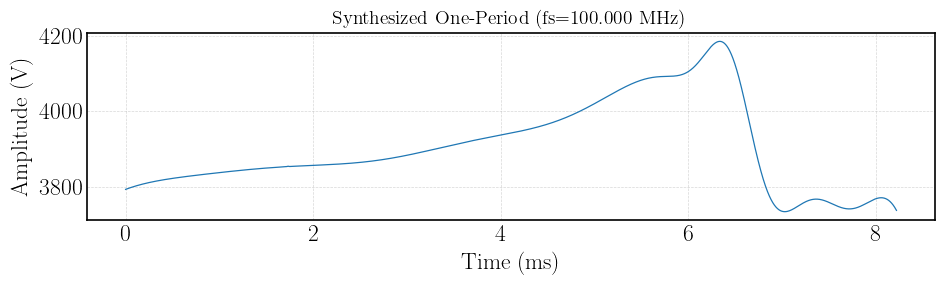

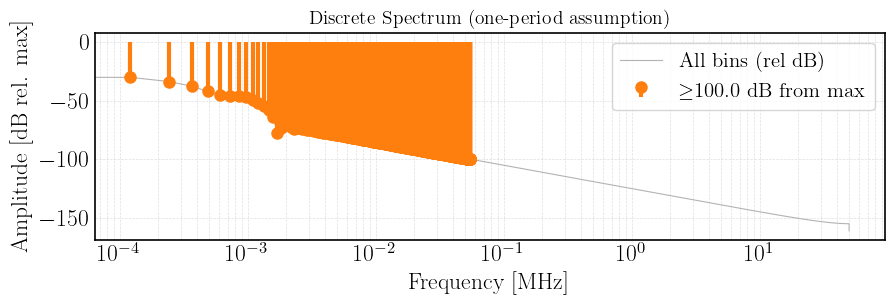

In [6]:
x_best, dt_best = gen_one_period(best["fs"] )

tones, spec = period_spectrum_select_tones(
     x_best, best["fs"], dt_best,
     db_floor_db=best["db_floor_db"],
     plot_time=True,
     plot_spectrum=True,
     save_txt=False,
 )

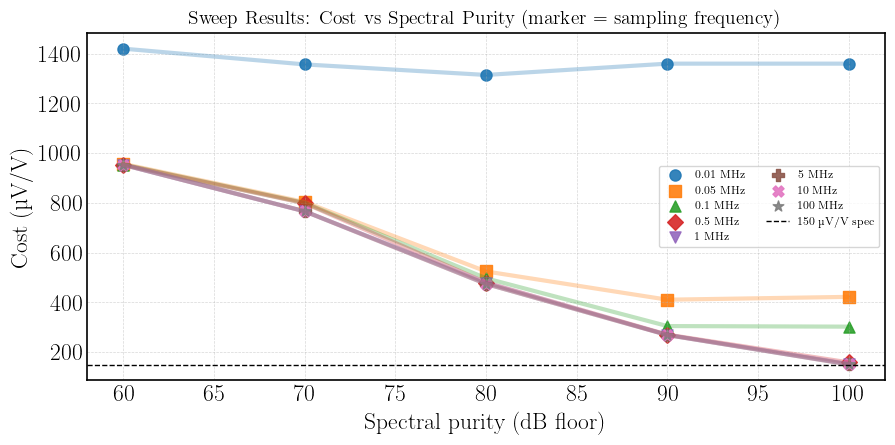

In [7]:
# --- Plot sweep: cost vs spectral purity (marker shape = sampling frequency) ---
fs_arr  = np.array([r['fs'] for r in results], dtype=float)
sp_arr  = np.array([r['db_floor_db'] for r in results], dtype=float)   # spectral purity (dB floor)
met_arr = np.array([r['metric_uV_per_V'] for r in results], dtype=float)

unique_fs = np.unique(fs_arr)
markers = ['o','s','^','D','v','P','X','*','h','>','<']  # shapes for different fs

plt.figure(figsize=(9.5, 5))
for i, fs in enumerate(unique_fs):
    m = markers[i % len(markers)]
    mask = (fs_arr == fs)
    x = sp_arr[mask]                  # spectral purity on X
    y = met_arr[mask]                 # cost on Y
    # (optional) sort by x for nicer traces:
    order = np.argsort(x)
    x, y = x[order], y[order]
    plt.scatter(x, y, marker=m, alpha=0.9, label=f"{fs/1e6:g} MHz")
    # (optional faint line to show trend per fs)
    plt.plot(x, y, alpha=0.3)

# horizontal spec line
thr = UV_PER_V_THRESHOLD
plt.axhline(thr, color="k", linestyle="--", linewidth=1, label=f"{thr:.0f} µV/V spec")

plt.xlabel("Spectral purity (dB floor)")
plt.ylabel("Cost (µV/V)")
plt.title("Sweep Results: Cost vs Spectral Purity (marker = sampling frequency)")
plt.grid(True, which="both", alpha=0.5)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

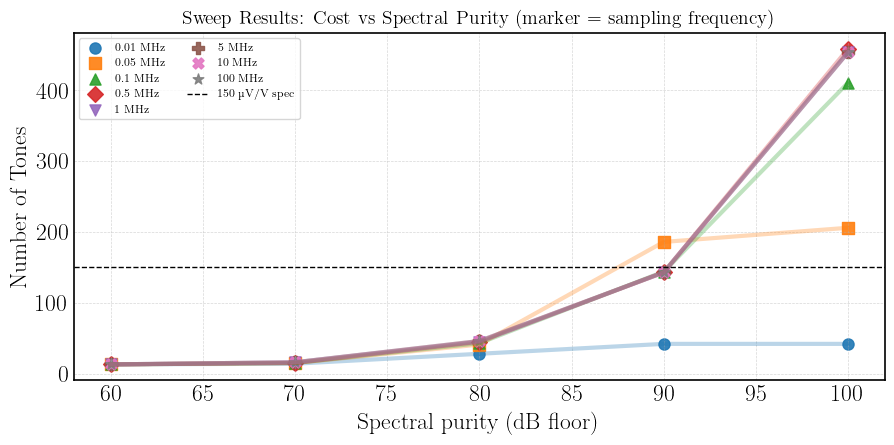

In [ ]:
# --- Plot sweep: cost vs spectral purity (marker shape = sampling frequency) ---
fs_arr  = np.array([r['fs'] for r in results], dtype=float)
sp_arr  = np.array([r['db_floor_db'] for r in results], dtype=float)   # spectral purity (dB floor)
tones_arr = np.array([r['num_tones'] for r in results], dtype=float)

unique_fs = np.unique(fs_arr)
markers = ['o','s','^','D','v','P','X','*','h','>','<']  # shapes for different fs

plt.figure(figsize=(9.5, 5))
for i, fs in enumerate(unique_fs):
    m = markers[i % len(markers)]
    mask = (fs_arr == fs)
    x = sp_arr[mask]                  # spectral purity on X
    y = tones_arr[mask]               # cost on Y
    # (optional) sort by x for nicer traces:
    order = np.argsort(x)
    x, y = x[order], y[order]
    plt.scatter(x, y, marker=m, alpha=0.9, label=f"{fs/1e6:g} MHz")
    # (optional faint line to show trend per fs)
    plt.plot(x, y, alpha=0.3)

# horizontal spec line

plt.xlabel("Spectral purity (dB floor)")
plt.ylabel("Number of Tones")
plt.title("Sweep Results: Cost vs Spectral Purity (marker = sampling frequency)")
plt.grid(True, which="both", alpha=0.5)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()